In [71]:
import numpy as np
from re import sub
import pandas as pd
import spacy as sp
import string
from bs4 import BeautifulSoup
import zipfile
import seaborn as sns
import string
import random
import matplotlib.pyplot as plt


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPool1D, Dense, Dropout,Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint




from tensorflow.keras import layers
import tensorflow_datasets as tfds

## Carregamento dos arquivos

In [2]:
colunas = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [3]:
treino = pd.read_csv('arquivos/train.csv', header = None,
                         names = colunas, engine = 'python', encoding = 'latin1')

In [4]:
treino.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
treino.sentiment.unique()

array([0, 4])

/home/rbtista/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


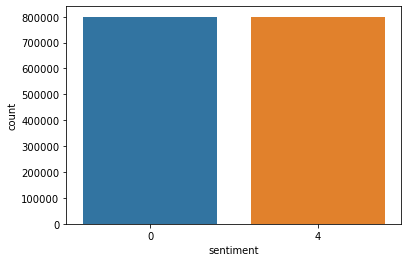

In [6]:
sns.countplot(treino.sentiment);

### Limpeza

In [10]:
treino.drop(['id', 'date', 'query', 'user'], axis = 1, inplace=True)

In [11]:
treino.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [12]:
treino.text = treino.text.apply(lambda x: sub(r"http\S+", '', str(x)))
treino.text = treino.text.apply(lambda x: sub(r"@[A-Za-z0-9]+", ' ', x))
treino.text = treino.text.apply(lambda x: sub(r"[^a-zA-Z.!?]", ' ', x))
treino.text = treino.text.apply(lambda x: sub(r" +", ' ', x))
treino.text = treino.text.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))   
treino.text = treino.text.apply(lambda x: x.lower())

In [13]:
treino.head()

,sentiment,text
0,0,awww that s a bummer you shoulda got david ca...
1,0,is upset that he can t update his facebook by ...
2,0,i dived many times for the ball managed to sa...
3,0,my whole body feels itchy and like its on fire
4,0,no it s not behaving at all i m mad why am i ...


In [14]:
# Obtendo o tamanho máximo da frase
tm = []
for t in treino.text:
    tm.append(len(t.split(' ')))
tamanho_txt = np.max(tm)
print('O tamanho máximo da frase é:', tamanho_txt)

O tamanho máximo da frase é: 118


In [15]:
tk = Tokenizer()
tk.fit_on_texts(treino.text.values)
idx = tk.word_index
total_palavras = len(idx)+1
print('Total de palavras no conjunto de dados únicas é:', total_palavras)

Total de palavras no conjunto de dados únicas é: 357776


In [16]:
# Frêquencia das palavras
minimo = 3
contagem = 0
total_contagem = 0
frequencia = 0
total_frequencia = 0

for key, value in tk.word_counts.items():
    total_contagem += 1
    total_frequencia += 1
    if(value < minimo):
        contagem +=1
        frequencia += 1
        
print('Palavras raras:', contagem)
print('Tamanho do vocabulário:', total_contagem)
print('Palavras mais comuns:', total_contagem-contagem)

Palavras raras: 275833
Tamanho do vocabulário: 357775
Palavras mais comuns: 81942


In [17]:
X = treino.iloc[:,1].values
y = treino.iloc[:,0].values

In [18]:
tk = Tokenizer(total_contagem-contagem)
tk.fit_on_texts(list(treino.text))

In [19]:
X = tk.texts_to_sequences(treino.text.values)
X = pad_sequences(X, maxlen=tamanho_txt, padding='post')
X.shape

(1600000, 118)

In [20]:
X

array([[  461,    16,    12, ...,     0,     0,     0],
       [    9,   780,    16, ...,     0,     0,     0],
       [    1, 54949,   312, ...,     0,     0,     0],
       ...,
       [   38,     7,   206, ...,     0,     0,     0],
       [  119,   284,   270, ...,     0,     0,     0],
       [  119, 17669,     0, ...,     0,     0,     0]], dtype=int32)

In [21]:
y[y==4]=1

In [65]:
y = pd.get_dummies(treino.sentiment.values)
y.shape

(1600000, 2)

In [66]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size=.2, stratify=y)

In [67]:
print(x_treino.shape, y_treino.shape)
print(x_teste.shape, y_teste.shape)

(1280000, 118) (1280000, 2)
(320000, 118) (320000, 2)


In [68]:
model = Sequential()
model.add(Embedding(total_contagem-contagem,128))
model.add(Conv1D(filters=50, kernel_size=2, padding='same', activation='relu'))
model.add(Conv1D(filters=50, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(filters=50, kernel_size=4, padding='same', activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [72]:
caminho = 'AnaliseDeSentimento_NGrama.h5'
parada = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)
check = ModelCheckpoint(caminho, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [74]:
modelo = model.fit(x_treino,y_treino, epochs=100, batch_size=128, verbose=1,
                  validation_data=(x_teste,y_teste), callbacks=[check,parada])

Epoch 1/100
10000/10000 [==============================] - 793s 79ms/step - loss: 0.3423 - accuracy: 0.8503 - val_loss: 0.3888 - val_accuracy: 0.8236

Epoch 00001: val_loss improved from inf to 0.38881, saving model to /media/rbtista/11D8AA336028BF21/modeloTreinado/AnaliseDeSentimento_NGrama.h5
Epoch 2/100
10000/10000 [==============================] - 784s 78ms/step - loss: 0.3071 - accuracy: 0.8684 - val_loss: 0.3969 - val_accuracy: 0.8245

Epoch 00002: val_loss did not improve from 0.38881
Epoch 3/100
10000/10000 [==============================] - 809s 81ms/step - loss: 0.2740 - accuracy: 0.8845 - val_loss: 0.4261 - val_accuracy: 0.8214

Epoch 00003: val_loss did not improve from 0.38881
Epoch 4/100
10000/10000 [==============================] - 827s 83ms/step - loss: 0.2446 - accuracy: 0.8978 - val_loss: 0.4875 - val_accuracy: 0.8132

Epoch 00004: val_loss did not improve from 0.38881
Epoch 5/100
10000/10000 [==============================] - 821s 82ms/step - loss: 0.2198 - accurac

In [75]:
loss, acc = model.evaluate(x_teste, y_teste, verbose=0)
print('Acurácia:', acc*100)

Acurácia: 80.88093996047974


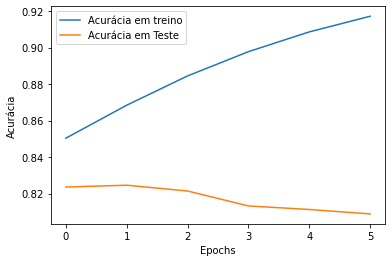

In [76]:
plt.plot(modelo.history['accuracy'])
plt.plot(modelo.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend(['Acurácia em treino','Acurácia em Teste'])
plt.show()

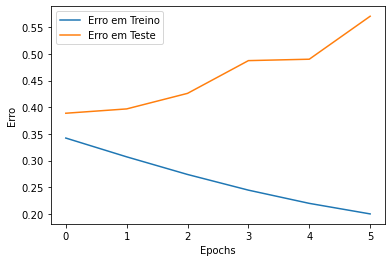

In [77]:
plt.plot(modelo.history['loss'])
plt.plot(modelo.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Erro')
plt.legend(['Erro em Treino','Erro em Teste'])
plt.show()